# Genetic Algorithm

### Genetic Algorithm의 Procedure
1. 선택(Selection): 현재 가능 해집합에서 우수한 해들을 선택하여 다음 세대를 생성하기 위한 부모 세대로 지정
2. 교배(Crossover): 선택된 부모 세대들의 유전자를 교환하여 새로운 세대를 생성
3. 돌연변이(Mutatioin): 낮은 확률로 변이를 발생시켜 Local Optimum에서 탈출할 수 있는 기회 제공

## Feature Selection을 위한 Genetic Algorithm 절차
1. 염색체 초기화 및 하이퍼 파라미터 설정 (Initiation)
2. 각 염색체 선택 변수별 모델 학습 
3. 각 염색체 적합도 평가 (Fitness Evaluation)
4. 우수 염색체 선택 (Selection)
5. 다음 세대 염색체 생성 (Crossover, Mutation)
6. 최종 변수 집합 선택

- 추가적으로 Population Size, Mutation Rate, Num of Generation, 적합도 함수 변경에 따른 Experiment 진행함

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from random import randint

In [6]:
# 데이터 불러오기
df_og = pd.read_csv("Parkinsson disease.csv")  # 파킨슨 질병 데이터셋 사용
df_og.drop(columns = ['name'], axis = 1, inplace=True)
df = df_og.copy()

In [7]:
# 독립 변수 및 종속 변수 할당
Y = df.status
X = df.drop(columns = ['status'], axis = 1)

print(Y.shape, X.shape)

(195,) (195, 22)


### Step1. 세대 초기화

In [8]:
def initiation_of_pop(size, n_feat): 
    population = []
    for i in range(size):
        chronosome = np.ones(n_feat, dtype = np.bool)
        chronosome[:int(0.5*n_feat)] = False         # Feature Selection을 위해 Binary로 염색체 인코딩 (50%의 변수는 사용하지 않음)
        np.random.shuffle(chronosome)                # False/False/False/ ..../True/True -> False/True/True/False/.../False와 같이 List Element 순서 Shuffle         
        population.append(chronosome)
    return population

### Step2, Step3 모델 학습 및 적합도 평가

In [9]:
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score          # 적합도 함수로 Accuracy 사용 (추후 풀게 될 문제 = Classification)

model = LogisticRegression(random_state=12, max_iter = 100)

def fitness_score(population):   
    scores = []
    for chronosome in population:
        model.fit(train_X.iloc[:,chronosome],train_Y)
        predictions = model.predict(test_X.iloc[:,chronosome])
        scores.append(accuracy_score(test_Y, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores) # Selection 단계에서 Deterministic하게 상위 n개의 Parents를 고르기 위한 사전 작업

    return list(scores[inds][::-1]), list(population[inds,:][::-1]) # score가 높은 것부터 낮은 것 순으로 정렬 및 population 안 chronosome 순서도 score를 기준으로 높은 것부터 낮은 것 순으로 정렬

In [10]:
# Step2에서 수립할 Classification 모델을 위한 Train/Test Set 생성
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, shuffle = True, random_state= 12)
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(136, 22) (136,) (59, 22) (59,)


### Step4. 부모 염색체 선택(Selection): Deterministic

In [11]:
def selection(pop_after_fit, n_parents):  # 상위 n_parents 개의 Chronosome을 Parent로 선택함
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i]) 
    return population_nextgen

### Step5. 교배 및 돌연변이

In [12]:
def crossover(pop_after_sel): 
    pop_nextgen = pop_after_sel

    for i in range(0, len(pop_after_sel),2):  # Crossover Point는 1개
        new_par = []
        child_1, child_2 = pop_nextgen[i], pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2], child_2[len(child_1)//2:]))   # Crossover Point는 각 Chronosome의 정중앙
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat): 
    mutation_range = int(mutation_rate*n_feat)      # e.g. mutation_rate = .2, n_feat = 10 -> mutation_range = 2 -> 2개의 gene 값을 변환(True -> False or False -> True)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)): 
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for _ in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for i in rand_posi:
            chromo[i] = not chromo[i]  # mutation 적용해서 0 -> 1 / 1 -> 0으로
        pop_next_gen.append(chromo)
    return pop_next_gen

### 위 Step들을 반복 수행(특정 Generation 횟수까지)하면서 최초 Generation 및 마지막 Generation의 Score 산출

In [13]:
# 위 함수들을 사용한 Genetic Algorithm 수행 
def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initiation_of_pop(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)

        if i == 0:
            print(f'Best score in first generation : {scores[:1]}')  # 첫 번째 Generation에서 Best Score

        elif i == n_gen-1:
            print(f'Best score in Last generation ({i+1}-th generation): {scores[:1]}') # 마지막 Generation에서 Best Score

        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [14]:
# Generation별 Best Score 시각화를 위한 함수 정의
def plot_gen_score(score,n_gen):
    gen = np.array(range(n_gen)) + 1
    plt.figure(figsize=(25,4))
    ax = sns.pointplot(x = gen, y = score, color = 'b')
    ax.set(xlabel = "Num of Generation", ylabel = "Accuracy")
    plt.xticks(rotation = 45)
    ax.set(ylim = (0.5,1))

Best score in first generation : [0.8983050847457628]
Best score in Last generation (100-th generation): [0.8813559322033898]


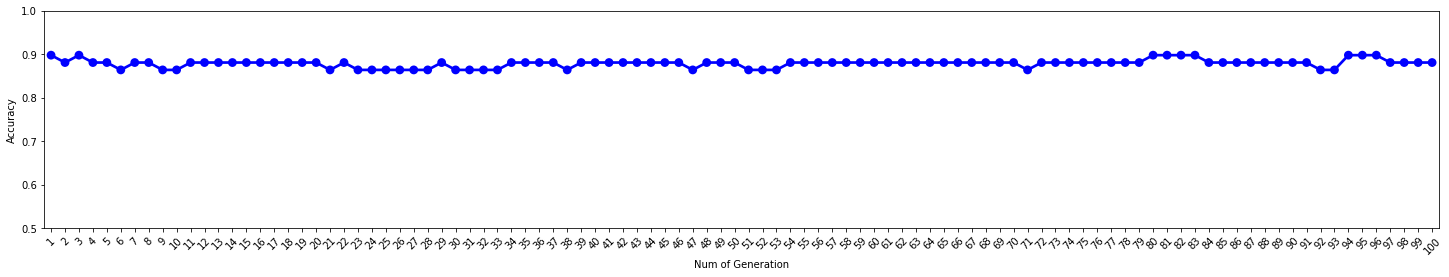

In [24]:
import warnings
warnings.filterwarnings("ignore")

pop_size = 40
n_parents = 5
n_gen = 100
mut_rate = .1

best_chromo, best_score = generations(X,Y, size = pop_size, n_feat = X.shape[1], n_parents = n_parents, mutation_rate = mut_rate, n_gen = n_gen, X_train = train_X, X_test = test_X, Y_train = train_Y, Y_test = test_Y)
plot_gen_score(best_score, n_gen)

# 하이퍼 파라미터 변경 테스트

## Chronosome의 수 (Population Size) 변경

=== Population Size = 10 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


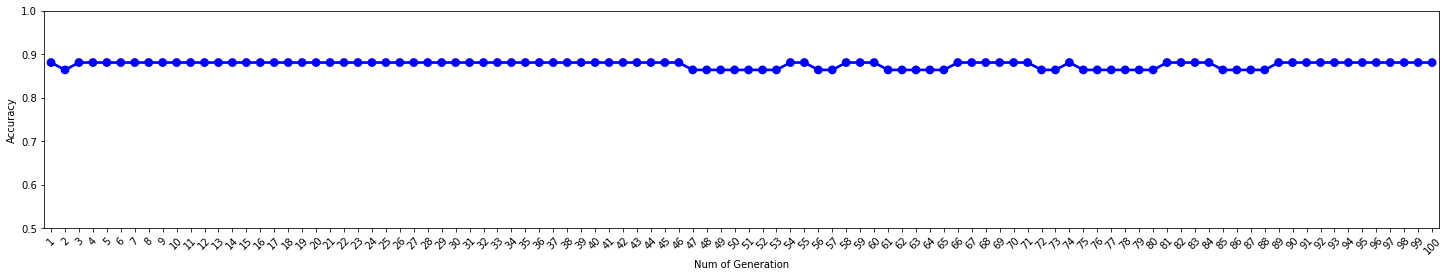

=== Population Size = 20 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


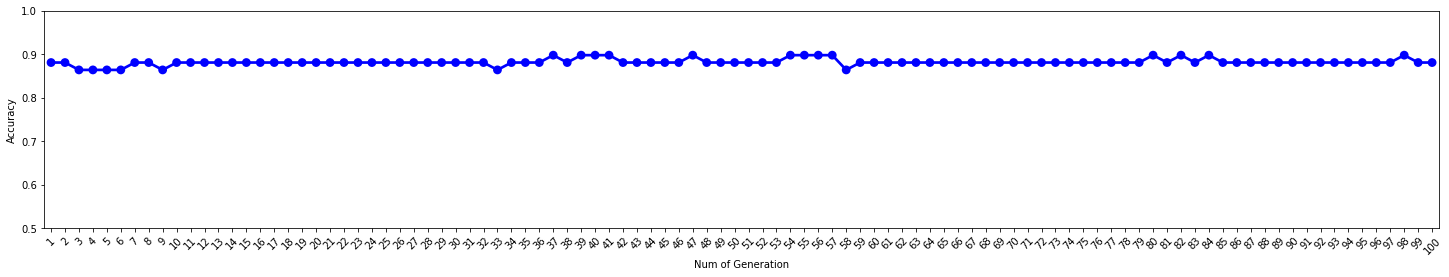

=== Population Size = 30 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


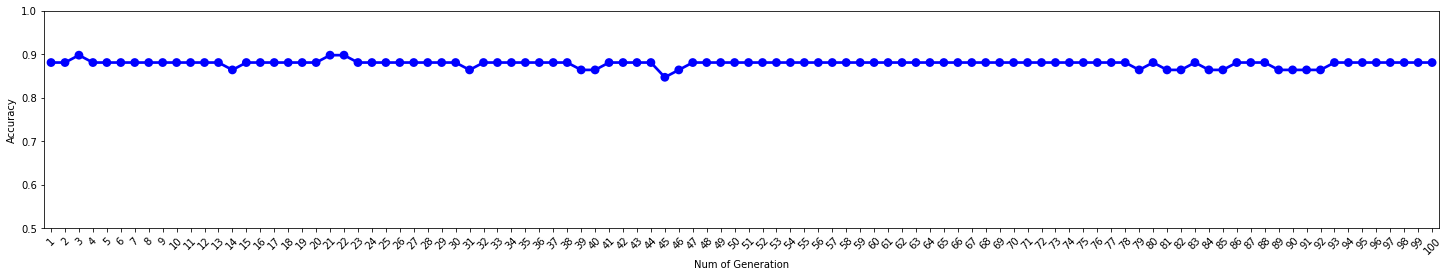

=== Population Size = 40 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


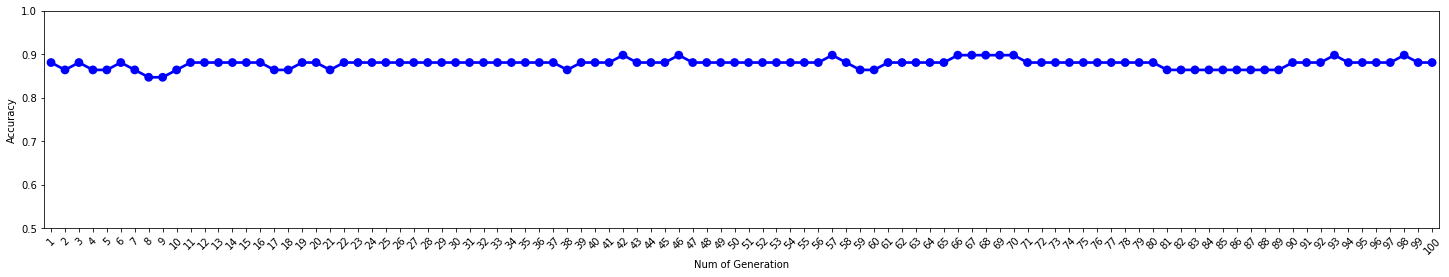

=== Population Size = 50 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


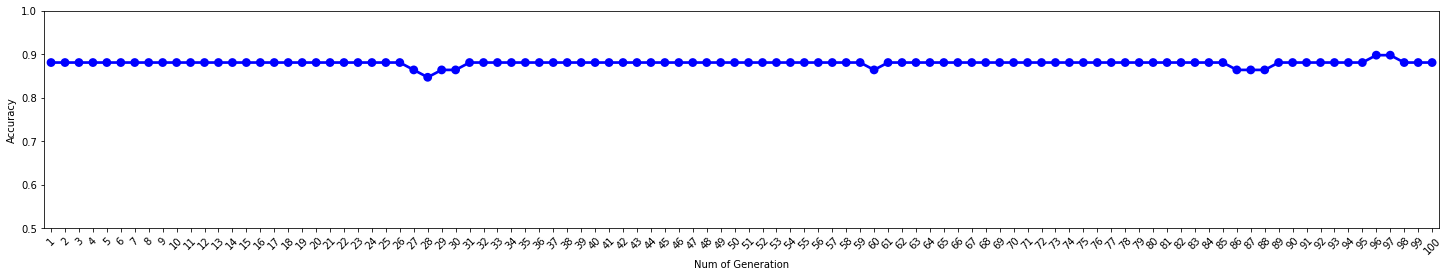

In [25]:
import warnings
warnings.filterwarnings("ignore")

pop_size = np.arange(10,50+1,10, dtype ='int')
n_parents = 5
n_gen = 100
mut_rate = .1

for p in pop_size:
    print(f'=== Population Size = {p} ===')
    best_chromo, best_score = generations(X,Y, size = p, n_feat = X.shape[1], n_parents = n_parents, mutation_rate = mut_rate, n_gen = n_gen, X_train = train_X, X_test = test_X, Y_train = train_Y, Y_test = test_Y)
    plot_gen_score(best_score, n_gen)
    plt.show()

## 돌연변이율 변경

=== Mutration Rate = 0.0 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


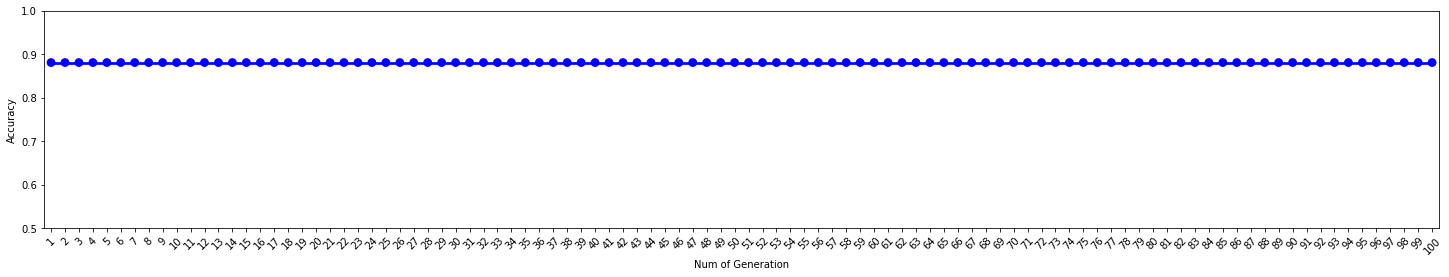

=== Mutration Rate = 0.1 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


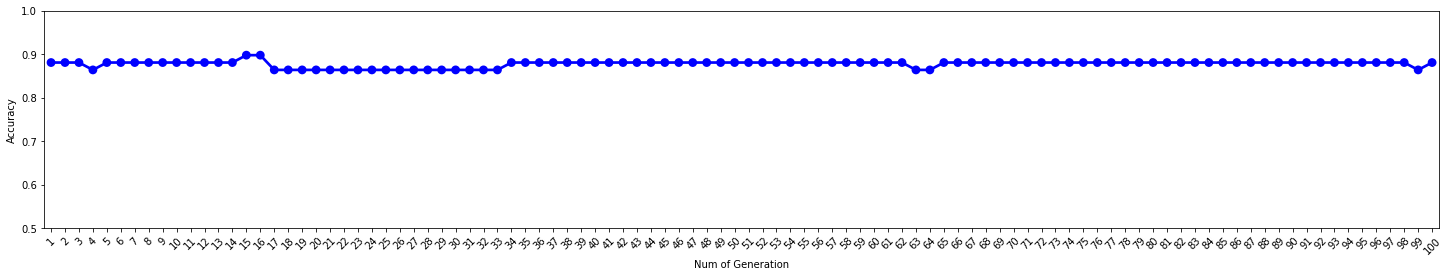

=== Mutration Rate = 0.2 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


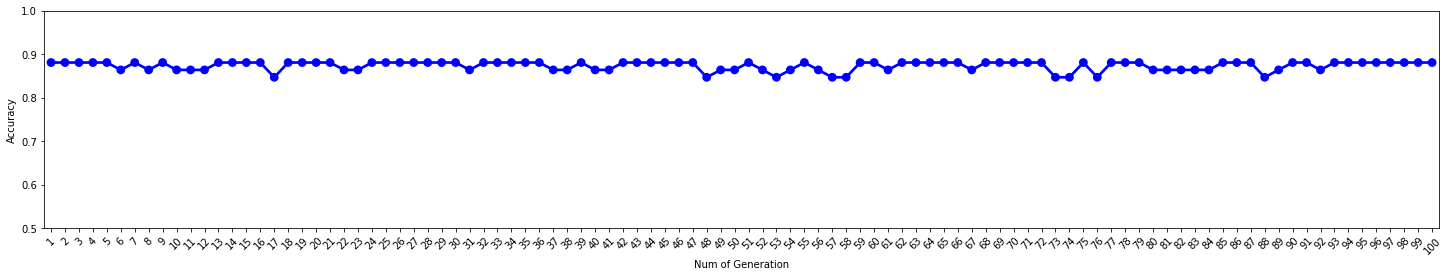

=== Mutration Rate = 0.3 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


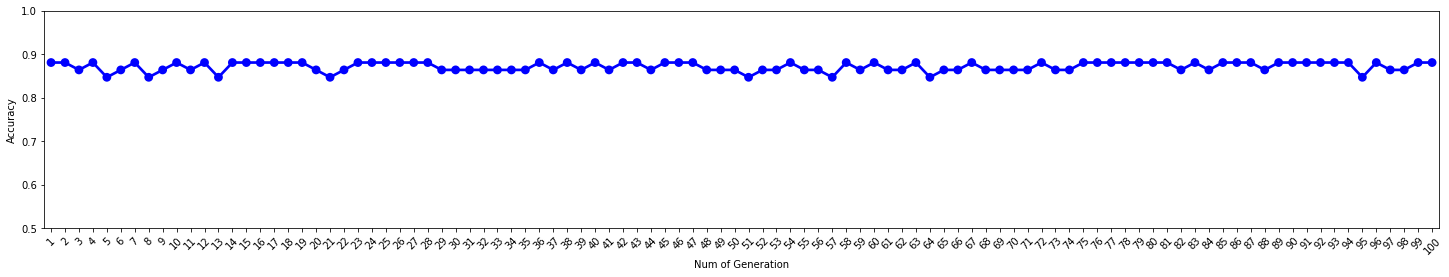

=== Mutration Rate = 0.4 ===
Best score in first generation : [0.864406779661017]
Best score in Last generation (100-th generation): [0.8813559322033898]


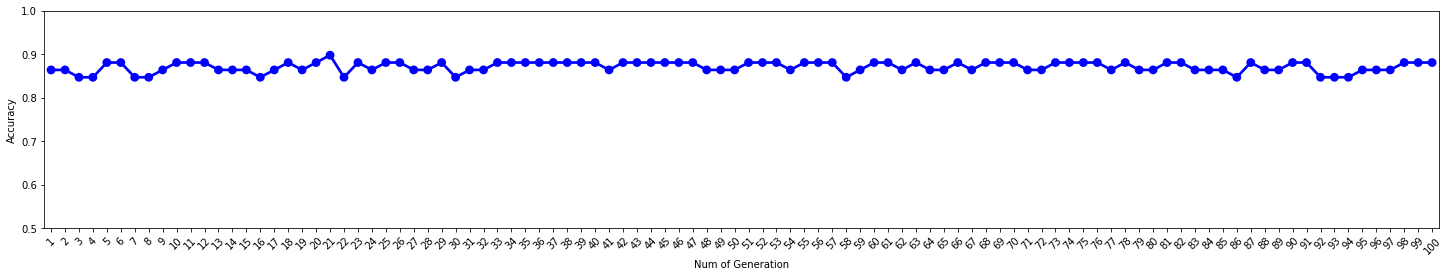

=== Mutration Rate = 0.5 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.864406779661017]


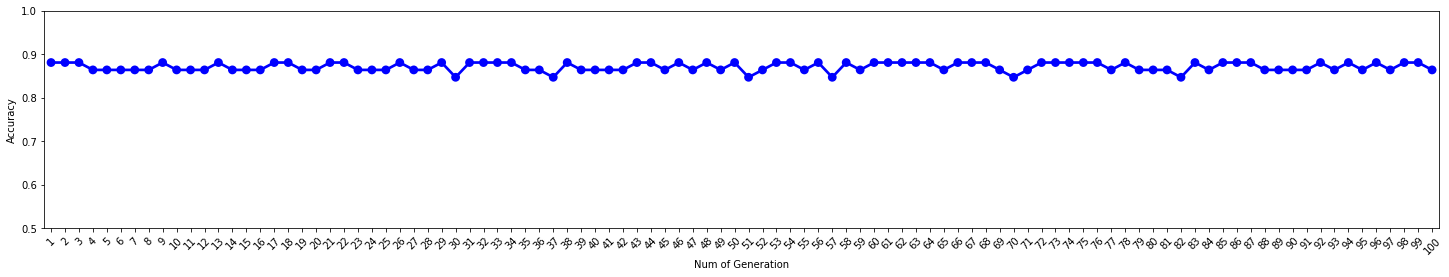

=== Mutration Rate = 0.6 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.864406779661017]


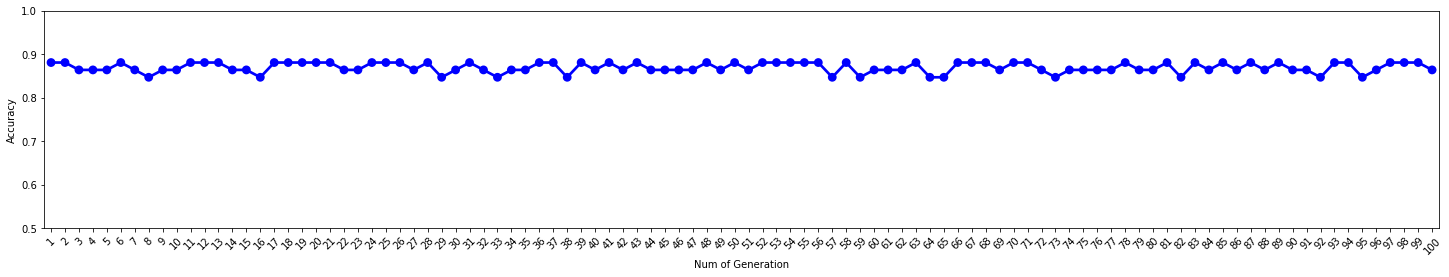

=== Mutration Rate = 0.7 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


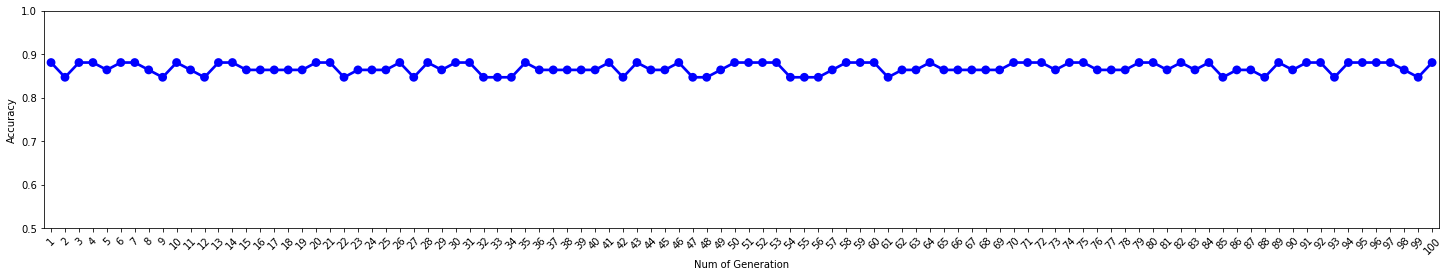

=== Mutration Rate = 0.8 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


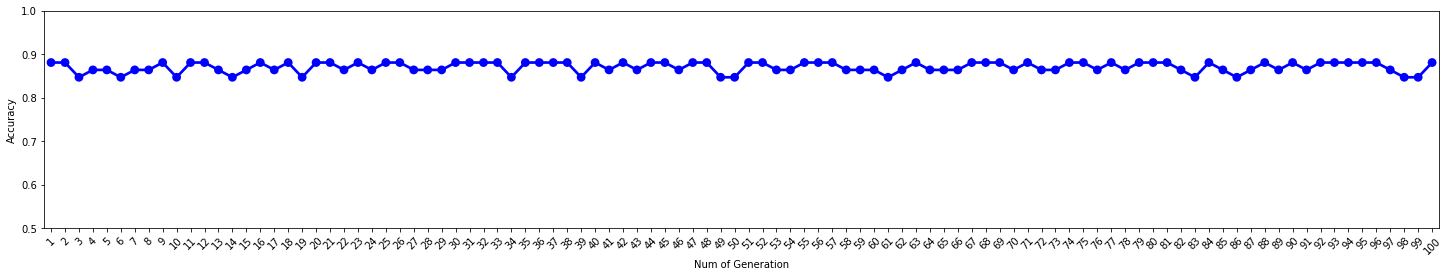

=== Mutration Rate = 0.9 ===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.864406779661017]


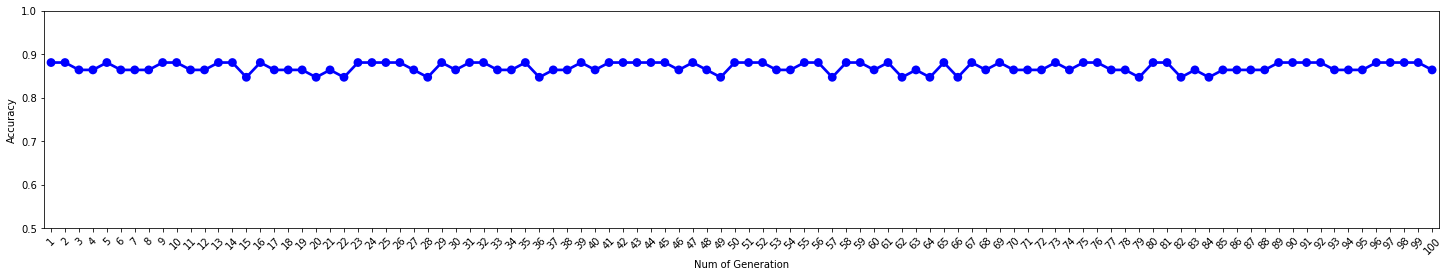

In [35]:
import warnings
warnings.filterwarnings("ignore")

pop_size = 40
n_parents = 5
n_gen = 100
mut_rate = np.arange(10)*.1  # [0, .1, .2 ,... .9] Test

for m in mut_rate:
    print(f'=== Mutration Rate = {m:.1f} ===')
    best_chromo, best_score = generations(X,Y, size = pop_size, n_feat = X.shape[1], n_parents = n_parents, mutation_rate = m, n_gen = n_gen, X_train = train_X, X_test = test_X, Y_train = train_Y, Y_test = test_Y)
    plot_gen_score(best_score, n_gen)
    plt.show()

## 종료 조건 중 Generation 수 변경

===Num of Generation = 50===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (50-th generation): [0.8813559322033898]


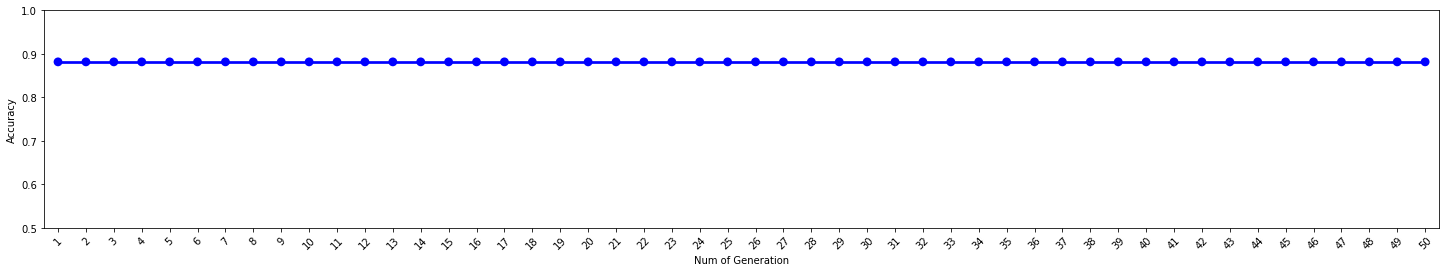

===Num of Generation = 100===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (100-th generation): [0.8813559322033898]


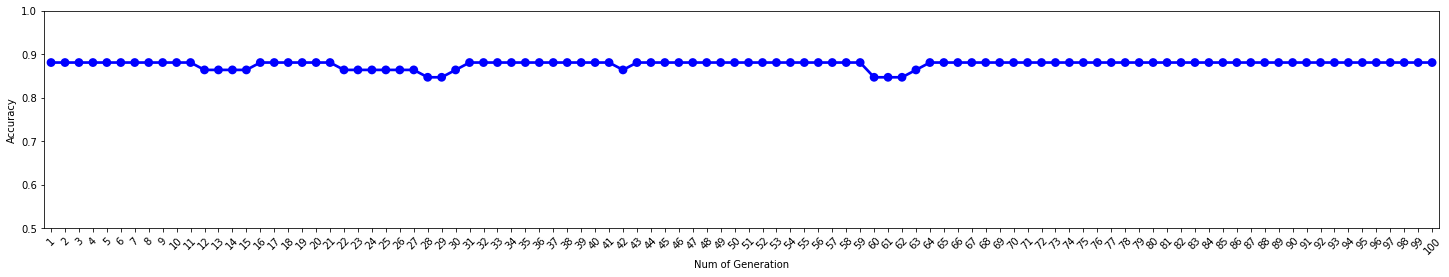

===Num of Generation = 150===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (150-th generation): [0.8813559322033898]


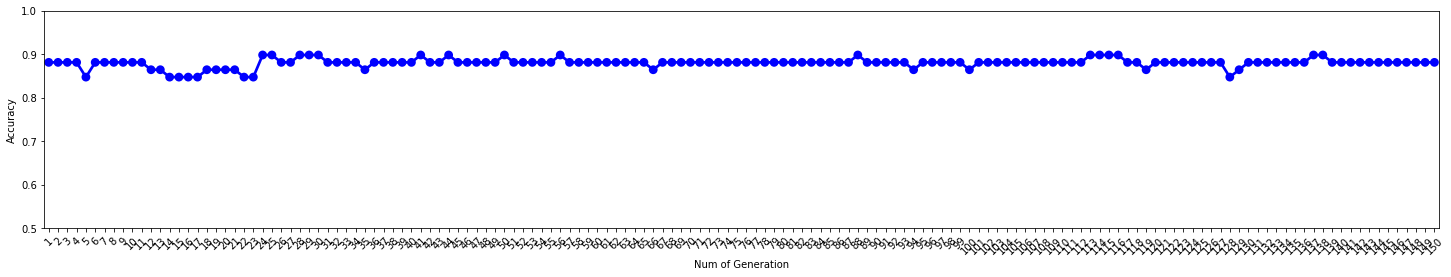

===Num of Generation = 200===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (200-th generation): [0.8813559322033898]


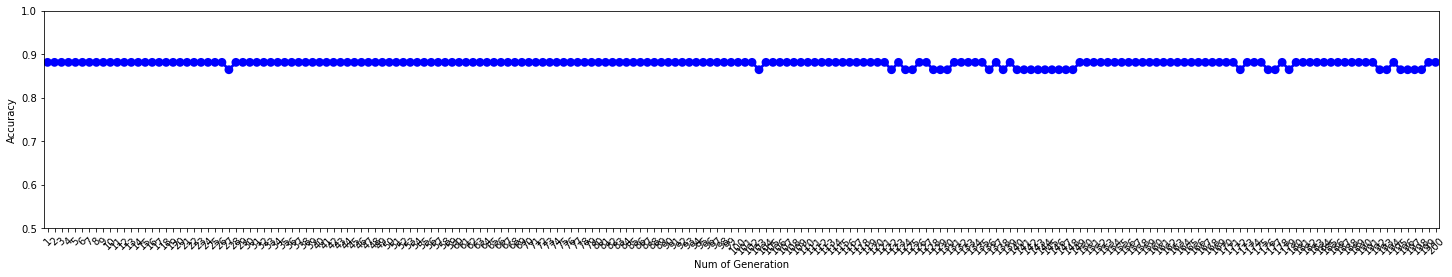

===Num of Generation = 250===
Best score in first generation : [0.8813559322033898]
Best score in Last generation (250-th generation): [0.8813559322033898]


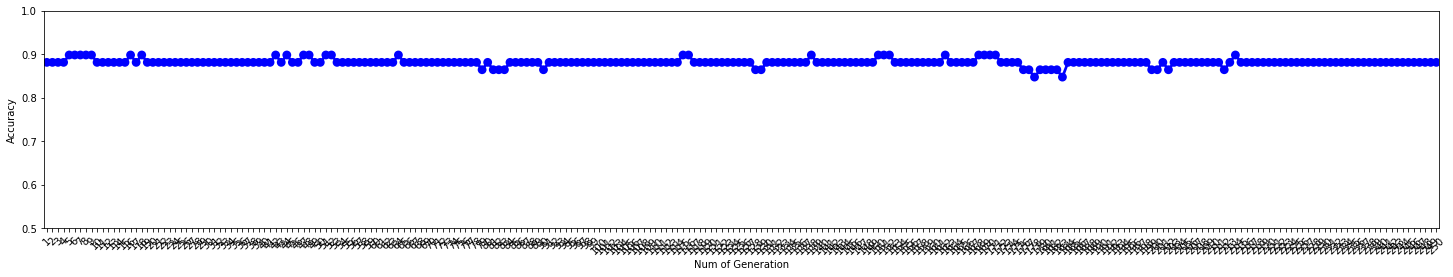

In [16]:
import warnings
warnings.filterwarnings("ignore")

pop_size = 40 
n_parents = 5
n_gen = np.arange(50, 250+1, 50, dtype = 'int')
mut_rate = .1

for n in n_gen:
    print(f"===Num of Generation = {n}===")
    best_chromo, best_score = generations(X,Y, size = pop_size, n_feat = X.shape[1], n_parents = n_parents, mutation_rate = mut_rate, n_gen = n, X_train = train_X, X_test = test_X, Y_train = train_Y, Y_test = test_Y)
    plot_gen_score(best_score, n)
    plt.show()

## 적합도 함수 변경

In [17]:
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import f1_score          # 적합도 함수로 F1-Score 사용

model = LogisticRegression(random_state=12, max_iter = 100)

def fitness_score(population):   
    scores = []
    for chronosome in population:
        model.fit(train_X.iloc[:,chronosome],train_Y)
        predictions = model.predict(test_X.iloc[:,chronosome])
        scores.append(f1_score(test_Y, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores) # Selection 단계에서 Deterministic하게 상위 n개의 Parents를 고르기 위한 사전 작업

    return list(scores[inds][::-1]), list(population[inds,:][::-1]) # score가 높은 것부터 낮은 것 순으로 정렬 및 population 안 chronosome 순서도 score를 기준으로 높은 것부터 낮은 것 순으로 정렬

Best score in first generation : [0.9130434782608695]
Best score in Last generation (100-th generation): [0.924731182795699]


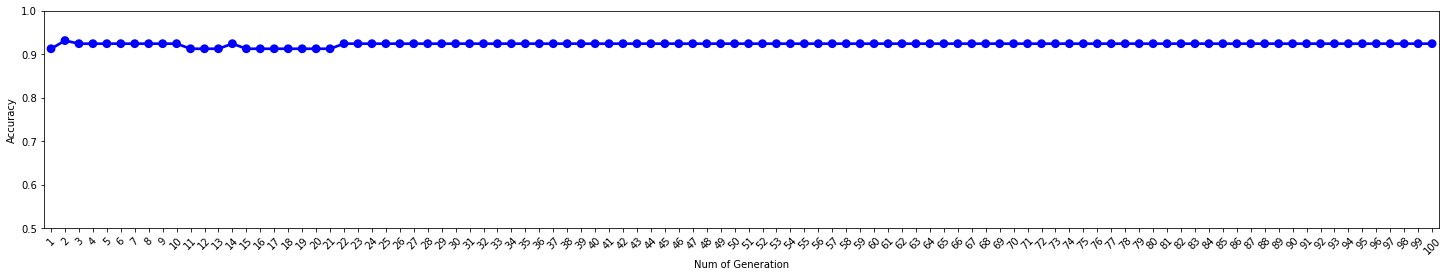

In [18]:
import warnings
warnings.filterwarnings("ignore")

pop_size = 40
n_parents = 5
n_gen = 100
mut_rate = .1

best_chromo, best_score = generations(X,Y, size = pop_size, n_feat = X.shape[1], n_parents = n_parents, mutation_rate = mut_rate, n_gen = n_gen, X_train = train_X, X_test = test_X, Y_train = train_Y, Y_test = test_Y)
plot_gen_score(best_score, n_gen)    